# Homework 2
**Christian Steinmetz**

Due on November 22nd

In [89]:
import sys
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

## Problem formulation
We set up an experimental framework to study various aspects of overfitting. 
The input space is $X = [−1, 1]$ with uniform input probability density, $P(x) =\frac{1}{2}$.
We consider the two models $\mathcal{H}_2$ and $\mathcal{H}_{10}$. 
The target function is a polynomial of degree $Q_f$, which we write as $f(x)=\sum_{q=0}^{Q_f} a_q L_q(x)$, where $Lq(x)$ are the Legendre polynomials.
We use the Legendre polynomials because they are a convenient orthogonal basis for the polynomials on $[−1, 1]$.
The first two Legendre polynomials are $L_0(x) = 1$, $L_1(x) = x$.
The higher order Legendre polynomials are defined by the recursion:

\begin{equation}
    L_k(x) = \frac{2k-1}{k} x L_{k-1}(x) - \frac{k-1}{k} L_{k-2}(x)
\end{equation}

The data set is $\mathcal{D} = (x_1, y_1), ..., (x_N , y_N)$, where $y_n = f (x_n)+\sigma \epsilon_n$ and $\epsilon_n$ are i.i.d. standard Normal random variables.

For a single experiment, with specified values for $Q_f$, $N$, $\sigma$, generate a random degree $Q_f$ target function by selecting coefficients $a_q$ independently from a standard Normal distribution, rescaling them so that $\mathbb{E}_{a,x}[f^2]=1$. Generate a data set, selecting
$x_1,...,x_N$ independently from $P(x)$ and $y_n = f (x_n)+\sigma \epsilon_n$. 

Let $g_2$ and $g_{10}$ be the best fit hypotheses to the data from $\mathcal{H_2}$ and $\mathcal{H}_{10}$, respectively, with respective out-of sample errors $E_{out}(g_2)$ and $E_{out}(g_{10})$.

In [11]:
def legendre_poly(k, x):
    if k == 0:
        return 1
    elif k == 1:
        return x
    else:
        return ((2*k-1)/k) * x * legendre_poly(k-1, x) - ((k-1)/k) * legendre_poly(k-2, x)

In [182]:
def generate_a_q(Q_f=None, seed=None):
    
    if seed:
        np.random.seed(seed)
    
    if not Q_f:
        # deteremine the degree, Q_f
        Q_f = np.random.randint(3, 10)
    
    if seed:
        np.random.seed(seed)
    
    # sample values for a_q
    a_q = np.random.standard_normal(size=Q_f)
    
    a_q[0] = 0 
    # for simplicity we hold the first coef at 0
    # which means that E(f(x)) = 0
    
    # normalize by finding the variance of f(x)
    if Q_f != 1:
        Ef2 = np.array([a**2/((2*q)+1) for q, a in enumerate(a_q)]).sum() + a_q[0]**2
        a_q /= np.sqrt(Ef2)
    
    return a_q

In [207]:
def generate_dataset(a_q, sigma, N, seed=None):
    
    if seed:
        np.random.seed(seed)
        
    X = (np.random.rand(N) * 2) - 1 # uniform over [-1, 1]    
    
    if len(a_q) == 1:
        Y = a_q[0] + (sigma * np.random.standard_normal(size=N))
    else:
        Y = np.polynomial.legendre.legval(X, a_q) + (sigma * np.random.standard_normal(size=N))

    return X, Y

In [247]:
a_q = generate_a_q(Q_f=10)
X, Y = generate_dataset(a_q, 0.0, 1000000)
print(f"X    mean: {X.mean():.2f}, var: {X.var():.2f}")
print(f"Y    mean: {Y.mean():.2f}, var: {Y.var():.2f}")

X    mean: 0.00, var: 0.33
Y    mean: 0.00, var: 1.00


**(a) Why do we normalize $f$?** [Hint: how would you interpret σ?]

We start we the following relationship for the variance, $Var[f] = E[f^2] - E[f]^2$, and we note that when we hold $a_0=0$, then $E[f]=0$, since all Legendre polynomials of order $> 0$ have zero mean meaning $E[f]=a_0$. This means that by applying our normalization of $f$ by setting $E[f^2]=1$, we can consider the output of our target function, $f$, as a continuous random variable with $E[f]=a_0$ and $Var(f)=1$.

Now considering the data generating function $y_n = f (x_n)+\sigma \epsilon_n$. We note that it is the sum of two random variables, the first term we described above, with some density as a function of $Q_f$ and $a_q$, and the second term constituting a noise term, ($wn = \sigma \epsilon_n$), with $E[wn]=0$ and $Var(wn)=\sigma$. We then consider the output of this data generation function a random variable with $E[y_n]=a_0$ and $Var(y_n)=\sigma$.

**(b) How can we obtain $g_2$, $g_{10}$?** [Hint: pose the problem as linear regression]

To find the best fit hypothesis we can use all of the datapoints in $D$ to fit a linear regression model within $\mathcal{H}_2$ and $\mathcal{H}_{10}$, where we attempt to minimize the in-sample error for each model. We use the common mean squared error as a loss function, which functions as an unbiased estimator. We build polynomial models of order 2 and order 10, from $\mathcal{H}_2$ and $\mathcal{H}_{10}$ respectively.


In [185]:
H_2 = preprocessing.PolynomialFeatures(degree=2)
X_2 = H_2.fit_transform(X.reshape(-1,1))

H_10 = preprocessing.PolynomialFeatures(degree=10)
X_10 = H_10.fit_transform(X.reshape(-1,1))

In [186]:
g_2 = LinearRegression(fit_intercept=True)
g_2.fit(X_2, Y)

g_10 = LinearRegression()
g_10.fit(X_10, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**(c) How can we compute $E_{out}$ analytically for a given $g_{10}$?**

Since we know the target function, $f$, and our best fit hypothesis will also provide a function, we can measure the distance between these to calculate $E_{out}$. A perfect prediction of $f$ will mean that our best fit hypothesis matches the exact same target function exactly. 

More generally, for any predicted target function $f_n$, we can define the expected error as 

\begin{equation}
\mathbb{E}_{err} = \int_{X \times Y} \mathcal{L}(f_n(x), y) \rho(x,y) dxdy
\end{equation}

where $\mathcal{L}$ is a loss function (ex: $\mathcal{L}(\hat{y}, y) = \mathbb{E}[ (y - \hat{y})^2 ]$)   and $\rho(x,y)$ is the joint probabaility of $x$ and $y$. 

Using our random variable model of the target function and our models and following the derivation of the [bias-variance decomposition](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), we know that the expected error for our best fit hypothesis $g(x)$, is given by 

\begin{equation}
E[(y_n-g(x))^2] = (\text{Bias}[g(x)])^2 + \text{Var}[g(x)] + \sigma^2
\end{equation}

where 

\begin{equation}
\text{Bias}[g(x)] = E[g(x)] - E[y_n(x)]
\end{equation}

and 

\begin{equation}
\text{Var}[g(x)] = E[g(x)^2] - E[g(x)]^2.
\end{equation}

**(d) Vary $Q_f$, $N$, $\sigma$ and for each combination of parameters, run a large number of experiments, each time computing $E_{out}(g_2)$ and $E_{out}(g_{10})$.**

Averaging these out-of-sample errors gives estimates of the expected out-of-sample error for the given learning scenario ($Q_f$, $N$, $\sigma$) using $\mathcal{H_2}$ and $\mathcal{H_{10}}$. 

Let 

\begin{equation}
    E_{out}(\mathcal{H}_2) = \text{average over experiments}(E_{out}(g_2)), \\
    E_{out}(\mathcal{H}_{10}) = \text{average over experiments}(E_{out}(g_{10})).
\end{equation}

Define the overfit measure $E_{out}(\mathcal{H}_{10}) − E_{out}(\mathcal{H}_2)$. When is the overfit measure significantly positive (i.e. overfitting is serious) as opposed to significantly
negative? Try the choices $Q_f \in \{1, 2,..., 100\}, N \in \{20, 25,..., 120\}, \sigma^2 \in \{0, 0.05, 0.1,..., 2\}$.

Explain your observations.

In [238]:
def fit_models(Q_f, N, s, plot=False):
    a_q = generate_a_q(Q_f=Q_f, seed=42)
    X, Y = generate_dataset(a_q, s, N, seed=42)
    
    H2 = preprocessing.PolynomialFeatures(degree=2, include_bias=True)
    X2 = H2.fit_transform(X.reshape(-1,1))
    g2 = LinearRegression(fit_intercept=True)
    g2.fit(X2, Y)
    
    H10 = preprocessing.PolynomialFeatures(degree=10, include_bias=True)
    X10 = H10.fit_transform(X.reshape(-1,1))
    g10 = LinearRegression()
    g10.fit(X10, Y)

    # this is an approx. of E_out
    x = np.linspace(-1,1,10000)
    y = np.polynomial.legendre.legval(x, a_q)
    y2_hat = g2.predict(H2.fit_transform(x.reshape(-1,1)))
    y10_hat = g10.predict(H10.fit_transform(x.reshape(-1,1)))
    
    # plot the results
    if plot:
        plt.plot(x, y2_hat)
        plt.plot(x, y10_hat)
        plt.scatter(X, Y, marker='.', c='k')
        plt.plot(x, y, linestyle='--', c='gray')
        plt.xlim([-1,1])
        plt.legend(['2nd Order Fit', '10th Order Fit','Target'])
        plt.show()
    
    E_out_g2  = (y2_hat**2).mean() + s
    E_out_g10 = (y10_hat**2).mean() + s
    
    return E_out_g2, E_out_g10
    

## Example plots

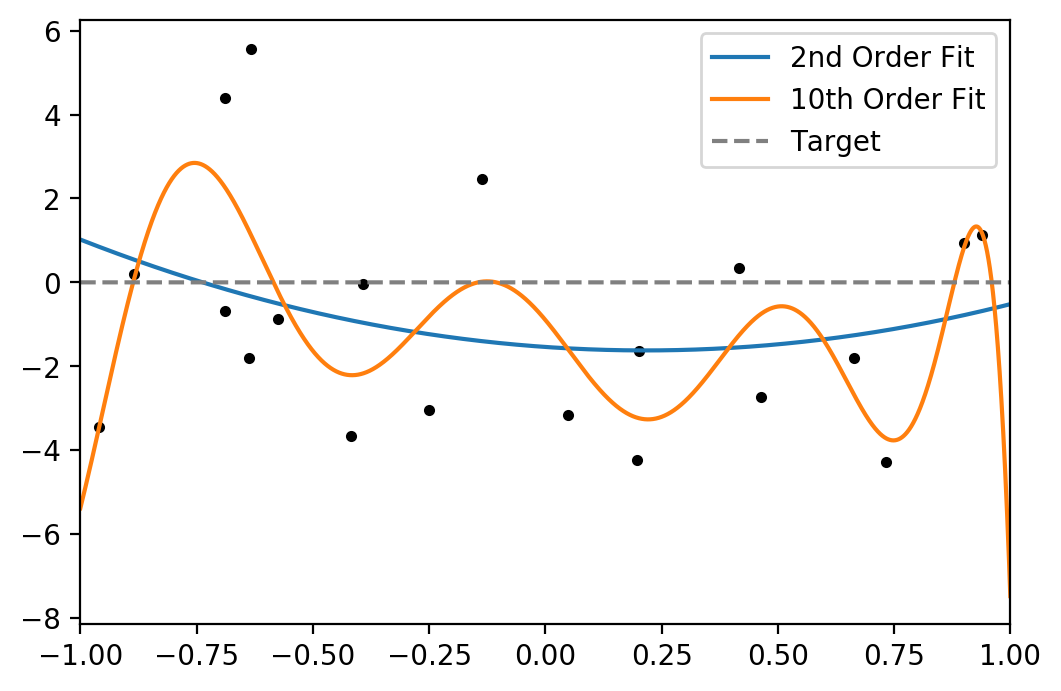

(4.373588990264794, 7.447882133115368)

In [239]:
fit_models(1, 20, 3.0, plot=True)

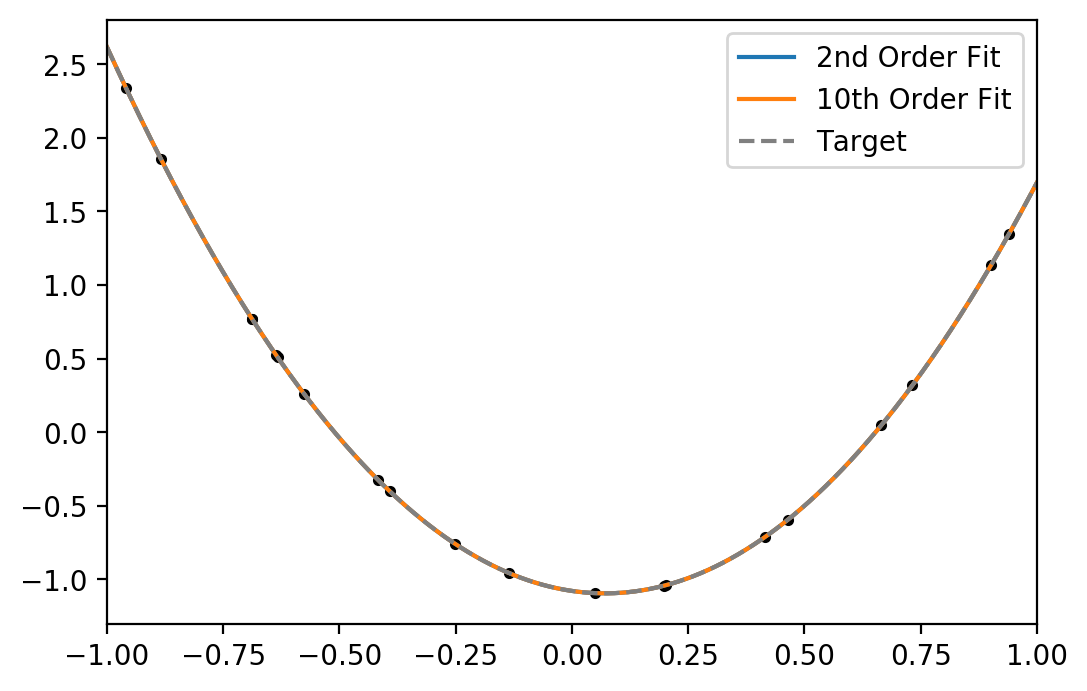

(1.0003859763437548, 1.000385976343756)

In [240]:
fit_models(3, 20, 0.0, plot=True)

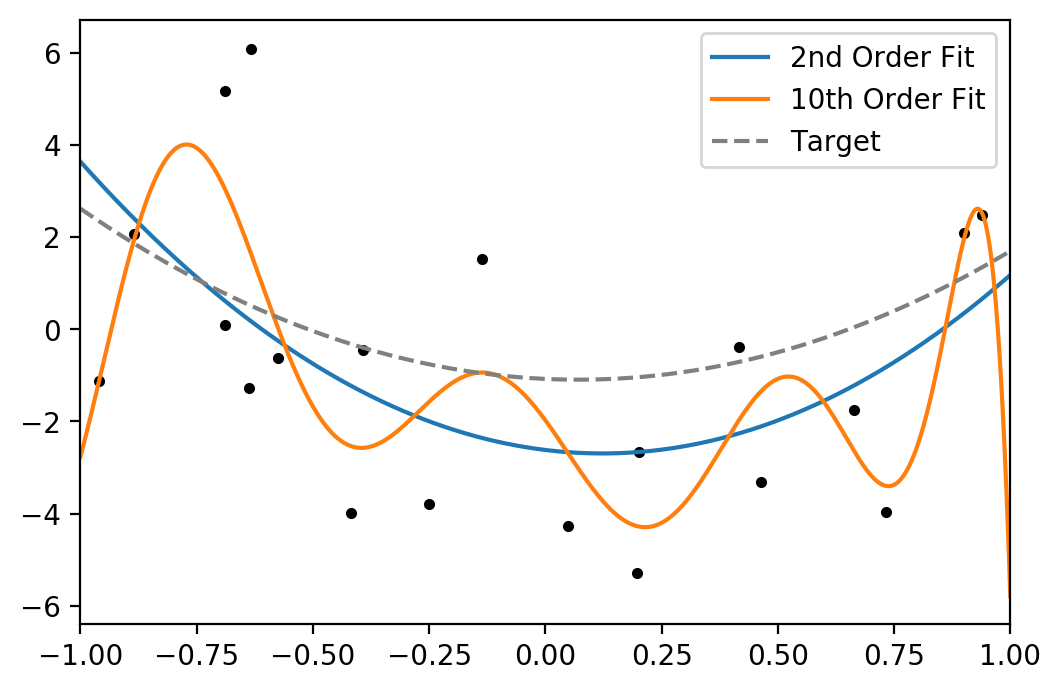

(6.6400946932045946, 9.26660449099439)

In [241]:
fit_models(3, 20, 3.0, plot=True)

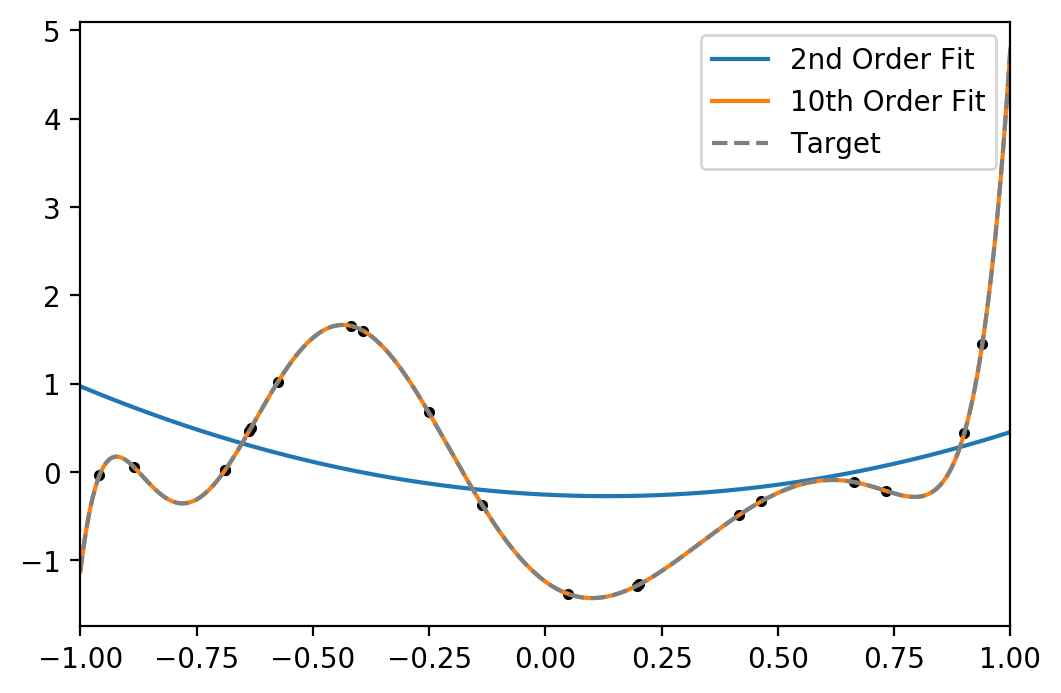

(0.10980900953472307, 1.001111218813407)

In [242]:
fit_models(10, 20, 0.0, plot=True)

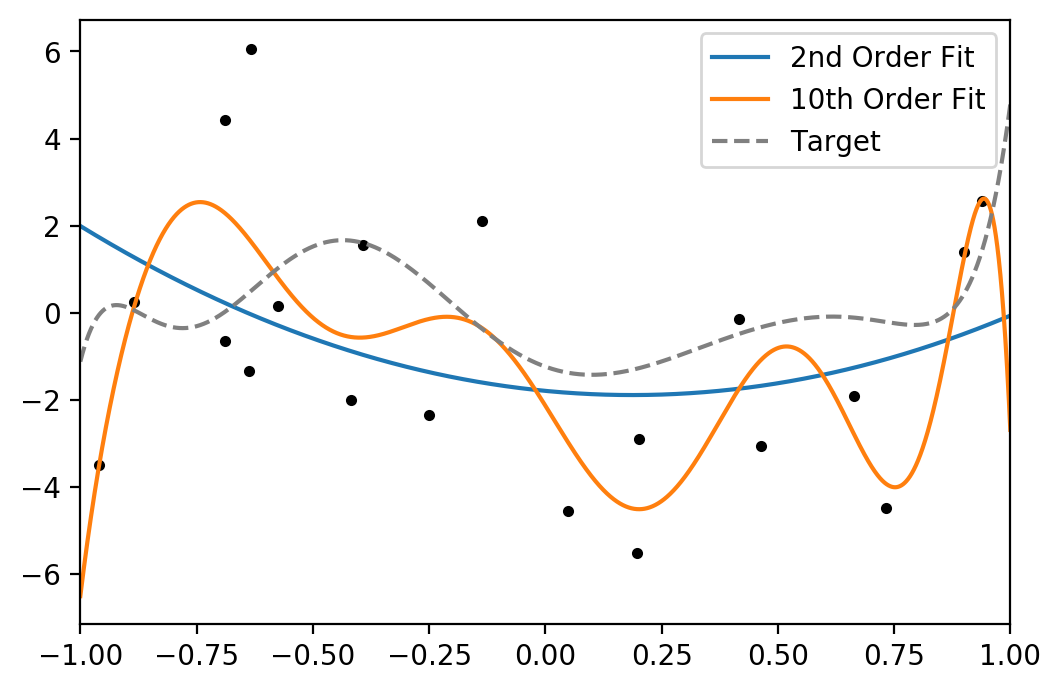

(4.8030721962871015, 8.665896445553901)

In [243]:
fit_models(10, 20, 3.0, plot=True)

In [250]:
Q_f = np.array([1, 2, 3, 4, 5, 10, 20, 50, 100])
N   = np.arange(20,121, 20)
Sig = [0.0, 0.5, 1.0, 3.0]
T   = np.arange(50)

n_iters = len(Q_f) * len(N) * len(Sig) * len(T)
iters = 0

logs = []

for q_f in Q_f:
    for n in N:
        for s in Sig:
            Eh2, Eh10 = [], []
            for t in T:
                Eg2, Eg10 = fit_models(q_f, n, s)
                Eh2.append(Eg2)
                Eh10.append(Eg10)
                iters += 1
                
                # print some progress
                sys.stdout.write(f"{iters:4d}/{n_iters:4d} - {(iters/n_iters)*100:2.2f}%\r")
                sys.stdout.flush()
            
            Eh2 = np.array(Eh2).mean()
            Eh10 = np.array(Eh10).mean()
            
            results = {
                "Q_f" : q_f,
                "N" : n,
                "s" : s,
                "E(H2)" : Eh2,
                "E(H10)" : Eh10,
                "o" : Eh10 - Eh2}
            
            logs.append(results)

In [251]:
for entry in logs:
    print({k:round(v,2) if isinstance(v,float) else v for k,v in entry.items()})

{'Q_f': 1, 'N': 20, 's': 0.0, 'E(H2)': 0.0, 'E(H10)': 0.0, 'o': 0.0}
{'Q_f': 1, 'N': 20, 's': 0.5, 'E(H2)': 0.54, 'E(H10)': 0.62, 'o': 0.09}
{'Q_f': 1, 'N': 20, 's': 1.0, 'E(H2)': 1.15, 'E(H10)': 1.49, 'o': 0.34}
{'Q_f': 1, 'N': 20, 's': 3.0, 'E(H2)': 4.37, 'E(H10)': 7.45, 'o': 3.07}
{'Q_f': 1, 'N': 40, 's': 0.0, 'E(H2)': 0.0, 'E(H10)': 0.0, 'o': 0.0}
{'Q_f': 1, 'N': 40, 's': 0.5, 'E(H2)': 0.5, 'E(H10)': 0.58, 'o': 0.07}
{'Q_f': 1, 'N': 40, 's': 1.0, 'E(H2)': 1.01, 'E(H10)': 1.3, 'o': 0.29}
{'Q_f': 1, 'N': 40, 's': 3.0, 'E(H2)': 3.1, 'E(H10)': 5.71, 'o': 2.61}
{'Q_f': 1, 'N': 60, 's': 0.0, 'E(H2)': 0.0, 'E(H10)': 0.0, 'o': 0.0}
{'Q_f': 1, 'N': 60, 's': 0.5, 'E(H2)': 0.51, 'E(H10)': 0.57, 'o': 0.06}
{'Q_f': 1, 'N': 60, 's': 1.0, 'E(H2)': 1.04, 'E(H10)': 1.26, 'o': 0.23}
{'Q_f': 1, 'N': 60, 's': 3.0, 'E(H2)': 3.35, 'E(H10)': 5.38, 'o': 2.03}
{'Q_f': 1, 'N': 80, 's': 0.0, 'E(H2)': 0.0, 'E(H10)': 0.0, 'o': 0.0}
{'Q_f': 1, 'N': 80, 's': 0.5, 'E(H2)': 0.51, 'E(H10)': 0.54, 'o': 0.03}
{'Q_f':

It is very clear that as we increase the level of noise in the training data, our lower complexity best fit hypothesis, $g_2$, tends to always produce much lower expected error in comparison to the larger complexity model, regardless of the order of the target function or the numer of training samples (for the dataset sizes tested here). This demonstrates the Occam's razor principle, that we ought to favor a more simpler hypothesis, which will tend to generalize much better. 

Most interestingly, even with there is no noise and the target function is of order 10, the same order as our complex model, the lower complexity model show lower predicted error. 

**(e) Why do we take the average over many experiments?** Use the variance to select an acceptable number of experiments to average over.

The sampling process used to create a dataset from the data generating function will create some level of variation in the data that the model gets to see during training, and when this sample is very small it will not be fully representative of the true underlying distribution that the model is trying to replicate. Therefore, taking multiple trials over different samples means that our estimation of the true $E_{out}$ for each of the hypothesis sets closer to the true value. 